<a href="https://colab.research.google.com/github/juliuswiscmsba/flower-classification-with-TF/blob/main/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from functools import partial
import numpy as np
 

(test_set_raw, valid_set_raw, train_set_raw), info = tfds.load('tf_flowers', split=['train[:10%]', 'train[10%:25%]', 'train[25%:]']
,as_supervised=True, with_info=True)
data_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

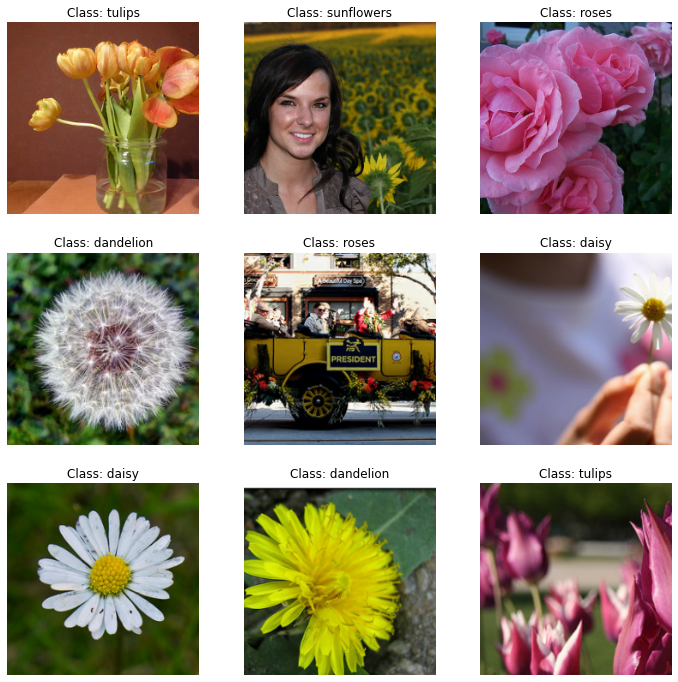

In [3]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

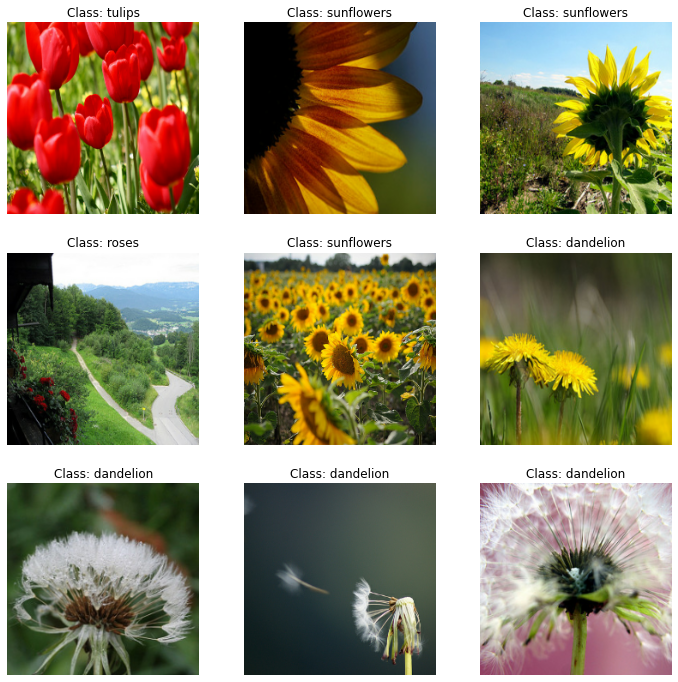

In [4]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [5]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 1s 0us/step


In [6]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * data_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * data_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 28s 150ms/step - loss: 1.4009 - accuracy: 0.8009 - val_loss: 1.0272 - val_accuracy: 0.8493
Epoch 2/5
86/86 [==============================] - 13s 148ms/step - loss: 0.5665 - accuracy: 0.8990 - val_loss: 0.8931 - val_accuracy: 0.8438
Epoch 3/5
86/86 [==============================] - 13s 146ms/step - loss: 0.3634 - accuracy: 0.9208 - val_loss: 0.8699 - val_accuracy: 0.8456
Epoch 4/5
86/86 [==============================] - 13s 146ms/step - loss: 0.2225 - accuracy: 0.9368 - val_loss: 0.6879 - val_accuracy: 0.8676
Epoch 5/5
86/86 [==============================] - 13s 147ms/step - loss: 0.1884 - accuracy: 0.9499 - val_loss: 0.6805 - val_accuracy: 0.8713


In [7]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * data_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * data_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 60s 625ms/step - loss: 0.3356 - accuracy: 0.8950 - val_loss: 0.6104 - val_accuracy: 0.8732
Epoch 2/40
86/86 [==============================] - 53s 620ms/step - loss: 0.1301 - accuracy: 0.9560 - val_loss: 0.3276 - val_accuracy: 0.9099
Epoch 3/40
86/86 [==============================] - 53s 621ms/step - loss: 0.0676 - accuracy: 0.9789 - val_loss: 0.3352 - val_accuracy: 0.9081
Epoch 4/40
86/86 [==============================] - 54s 623ms/step - loss: 0.0354 - accuracy: 0.9873 - val_loss: 0.2631 - val_accuracy: 0.9228
Epoch 5/40
86/86 [==============================] - 54s 624ms/step - loss: 0.0365 - accuracy: 0.9898 - val_loss: 0.2796 - val_accuracy: 0.9191
Epoch 6/40
86/86 [==============================] - 54s 623ms/step - loss: 0.0282 - accuracy: 0.9924 - val_loss: 0.2749 - val_accuracy: 0.9228
Epoch 7/40
86/86 [==============================] - 53s 622ms/step - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.2590 - val_accuracy: 0.9320

In [8]:
predict = model.predict(test_set)

12/12 [==============================] - 3s 197ms/step


In [9]:
predict_index = np.argmax(predict, axis=-1)
predict_class=[]
for i in predict_index:
  predict_class.append(class_names[i])

In [10]:
test_label=[]
for _, y_batch in test_set:
     for i in y_batch:
       test_label.append(class_names[int(i)])

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(test_label, predict_class)

0.9346049046321526

Text(33.0, 0.5, 'Real')

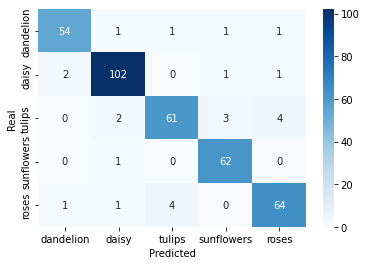

In [12]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_label, predict_class), annot=True, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Real')